In [1]:
from scipy import io
import GPy
import numpy as np
import matplotlib.pyplot as plt
import pylab as pb
import GPy.inference.latent_function_inference.exact_gaussian_inference as eg

In [2]:
def plot_2outputs(m,xlim,x_1,x_2):
    fig = pb.figure(figsize=(12,8))
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,len(x_1)),ax=ax1)

    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(len(x_1),len(x_1)+len(x_2)),ax=ax2)

In [3]:
def build_XY(input_list,output_list=None):
    num_outputs = len(input_list)
    Y = np.vstack(output_list)
    I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )
    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])
    I = {'output_index':I[:,None]}
    return X,Y,I

In [4]:
mat_file1 = io.loadmat('2014_Dataset1.mat')
t_d1 = mat_file1['t']
p1_d1 = mat_file1['p1']
p2_d1 = mat_file1['p2']
t_d1 = t_d1*24

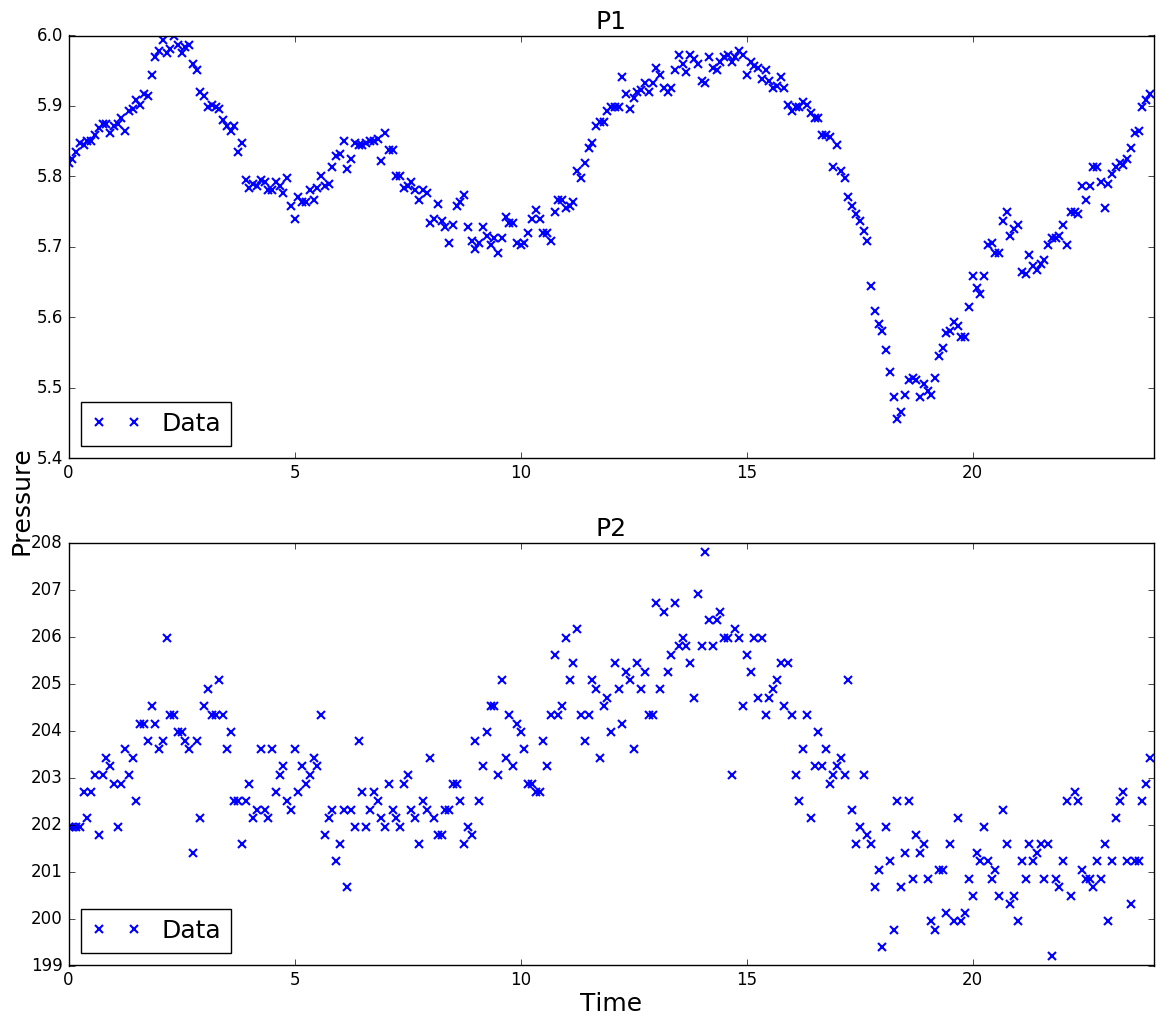

In [15]:
fig = pb.figure(figsize=(14,12))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)

plt.xlabel('Time',fontsize=18)
plt.ylabel('Pressure',fontsize=18)

ax1 = fig.add_subplot(211)
ax1.tick_params(labelsize=12)
ax1.set_title('P1',fontsize=18)
ax1.set_xlim([0,24])
ax1.plot(t_d1[0:288],p1_d1[0:288],'bx',mew=1.5,label='Data')
ax1.legend(loc=3,fontsize=18)

ax2 = fig.add_subplot(212)
ax2.tick_params(labelsize=12)
ax2.set_title('P2',fontsize=18)
ax2.set_xlim([0,24])
ax2.plot(t_d1[0:288],p2_d1[0:288],'bx',mew=1.5,label='Data')
ax2.legend(loc=3,fontsize=18)

fig.savefig('1.png')
plt.show()

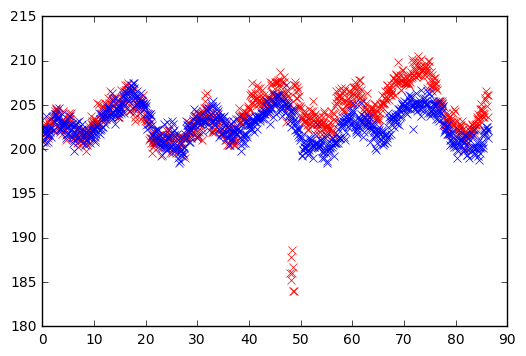

In [5]:
le = 288*3
x_d1 = np.arange(0,le/10,0.1)
x_d1 = np.reshape(x_d1,[len(x_d1),1])

start = 8928-288*1
p1_d1_test = p1_d1[start:start+le]
p2_d1_test = p2_d1[start:start+le]
y1_d1 = p1_d1_test
y2_d1 = p2_d1_test

#Training set
start_t = 8928-288*4
p1_d1_t = p1_d1[start_t:start_t+le]
p2_d1_t = p2_d1[start_t:start_t+le]
y1_d1_t = p1_d1_t
y2_d1_t = p2_d1_t

plt.plot(x_d1,y2_d1,'kx',color='red')
plt.plot(x_d1,y2_d1_t,'kx',color='blue')

plt.show()

In [6]:
def rbf(x1,x2,m):
    k = (np.absolute(x1,x2)**2)/(2*(2*m.kern.ICM0.rbf.lengthscale[0])**2)
    ke = np.exp(-k)
    return ke

In [7]:
test_x = x_d1[len(x_d1)-1]+0.1
n = 0
for i in range(len(x_d1)):
    n += rbf(x_d1[i],test_x,mul1)

NameError: name 'mul1' is not defined

In [8]:
alpha = 2*np.log(n)**(-0.5)
beta = (2*np.log(n))**(0.5) - (np.log(np.log(n)+np.log(2*np.pi)))/(2*(2*np.log(n))**0.5)
zp = beta-alpha*np.log(-np.log(0.95))
zp

 C:\Users\Woojin Cho\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning:divide by zero encountered in log
 C:\Users\Woojin Cho\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning:divide by zero encountered in log
 C:\Users\Woojin Cho\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning:invalid value encountered in log


nan

In [9]:
K1 = GPy.kern.RBF(1)
K2 = GPy.kern.PeriodicExponential(1)

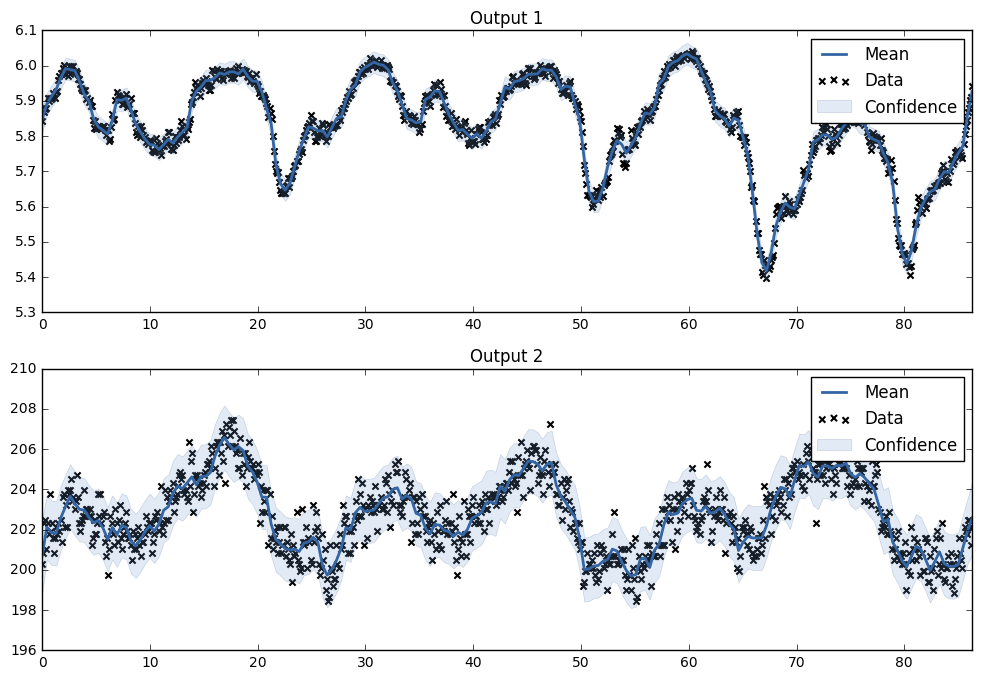

In [26]:
lcm1 = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[K1,K2])
mul1 = GPy.models.GPCoregionalizedRegression([x_d1,x_d1],[y1_d1_t,y2_d1_t],kernel = lcm1)
# mul1['.*periodic_Matern32.period'].constrain_fixed(28.8)
mul1.optimize()
plot_2outputs(mul1, xlim=(0,x_d1[len(x_d1)-1]),x_1=x_d1,x_2=x_d1)
plt.show()

In [28]:
mul1

gp.,value,constraints,priors
sum.ICM0.rbf.variance,18.5755776138,+ve,
sum.ICM0.rbf.lengthscale,1.71055042518,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.periodic_exponential.variance,0.0414810035169,+ve,
sum.ICM1.periodic_exponential.lengthscale,3.08414759674,+ve,
sum.ICM1.periodic_exponential.period,7.19676421584,+ve,
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,0.000218981083259,+ve,


In [8]:
def output2_vector_covariance(K, train_size):
    m = int((K.shape[0] - 2*train_size)/2)
    #첫번째 input들의 covariance vector
    k1star = 0
    for i in range(train_size):
        if i == 0:
            k1star = K[i][train_size:train_size + m]
        else:
            k1star = np.vstack([k1star, K[i][train_size:train_size + m]])
    
    #첫번째와 두번째 input간의 covariance vector    
    k2star = 0
    for i in range(train_size):
        if i == 0:
            k2star = K[i][train_size + m + train_size:train_size + m + train_size + m]
        else:
            k2star = np.vstack([k2star, K[i][train_size + m + train_size:train_size + m + train_size + m]])
    k3star = k2star.copy()
    
    #두번째 input들의 covariance vector
    k4star = 0
    for i in range(train_size):
        if i == 0:
            k4star = K[i + train_size + m][train_size + m + train_size:train_size + m + train_size + m]
        else:
            k4star = np.vstack([k4star, K[i + train_size + m][train_size + m + train_size:train_size + m + train_size + m]])
    
    #combine
    k1 = np.column_stack([k1star,k2star])
    k2 = np.column_stack([k3star,k4star])
    k = np.vstack([k1,k2])
    return k

In [9]:
def predictive_mean_variance(K, K_original, y, K_star, train_size):
    m = int((K.shape[0] - 2*train_size)/2)
    kstar = output2_vector_covariance(K, train_size)
    #(K+sigma)^-1 *y
    Wi, LW, LWi, W_logdet = GPy.util.linalg.pdinv(K_original)
    alpha1, _ = GPy.util.linalg.dpotrs(LW, y, lower=1)
    #prediction mean
    f_bar = np.dot(kstar.transpose(),alpha1)
    
    #(K+sigma)^-1 *kstar
    alpha2, _ = GPy.util.linalg.dpotrs(LW, kstar, lower=1)
    #prediction variance matrix
    V_f = K_star - np.dot(kstar.transpose(),alpha2)
    
    return f_bar, V_f

In [10]:
def make_test(training_x, training_y1, training_y2, test_x, test_y1, test_y2):
    x_set1 = np.vstack([training_x,test_x])
    x_set2 = x_set1.copy()
    x = [x_set1, x_set2]
    y_set1 = np.vstack([training_y1,test_y1])
    y_set2 = np.vstack([training_y2,test_y2])
    y = [y_set1, y_set2]
    X,Y,I = build_XY(x,y)
    
    return X,Y

In [11]:
def pred_likelihood(m, X, Y, kernel, training_size):
    log_2_pi = np.log(2*np.pi)
    t = int((len(X) - 2*training_size)/2)
    x1 = X[0:training_size]
    x2 = X[training_size + t:2*training_size + t]
    x = np.vstack([x1,x2])                                     #training x

    x1_new = X[training_size:training_size + t]
    x2_new = X[2*training_size + t:2*training_size + 2*t]
    x_t = np.vstack([x1_new,x2_new])                           #test x
    
    y1 = Y[0:training_size]
    y2 = Y[training_size + t:2*training_size + t]
    y = np.vstack([y1,y2])                                     #training y
    
    y1_new = Y[training_size:training_size + t]                #test y
    y2_new = Y[2*training_size + t:2*training_size + 2*t]
    y_t = np.vstack([y1_new,y2_new])  
    
    K_original = kernel.K(x)
    noise1 = m.mixed_noise.Gaussian_noise_0.variance[0]
    noise2 = m.mixed_noise.Gaussian_noise_1.variance[0]
    n1 = np.ones(training_size)*noise1
    n2 = np.ones(training_size)*noise2
    noise = np.diag(np.hstack([n1,n2]))
    
    K_original_noise = K_original + noise                      #training set에 noise더한거
    K = kernel.K(X)                                            #training과 test set이 합쳐져있는 K matrix
    K_star = kernel.K(x_t)                                     #test set의 K
    
    n1s = np.ones(t)*noise1
    n2s = np.ones(t)*noise2
    noise_s = np.diag(np.hstack([n1s,n2s]))
    
    f, V = predictive_mean_variance(K, K_original_noise, y, K_star, training_size)
    V = V + noise_s
    
    Vy = V.copy()
    Y_d = y_t - f
    
#     mu1 = np.average(y1)
#     mu2 = np.average(y_t)
#     ym1 = mu1*np.ones(int(len(y_t)/2))[:,None]
#     ym2 = mu2*np.ones(int(len(y_t)/2))[:,None]
#     m_lin = np.vstack([ym1,ym2])
#     Y_d = y_t - m_lin
 
    Wi, LW, LWi, W_logdet = GPy.util.linalg.pdinv(Vy)
    alpha, _ = GPy.util.linalg.dpotrs(LW, Y_d, lower=1)
#     print(Y_d)
    log_marginal_pred =  0.5*(-Y_d.size * log_2_pi - Y_d.shape[1] * W_logdet - np.sum(alpha * Y_d))
    
#     return log_marginal_pred,f,V
    return log_marginal_pred

In [12]:
X,Y = make_test(training_x = x_d1, training_y1 = y1_d1_t, training_y2 = y2_d1_t, test_x = x_d1[0:3], test_y1 = y1_d1[0:3], test_y2 = y2_d1[0:3])
pre_liket,f,V = pred_likelihood(mul1, X, Y, mul1.kern, len(x_d1))
print(f,V)

TypeError: 'numpy.float64' object is not iterable

In [13]:
# GPy 내장함수와 직접구현한 코드 결과 동일
X1,Y1,I1 = build_XY([x_d1[0:3],x_d1[0:3]],[y1_d1[0:3],y2_d1[0:3]])
mu,var = mul1.predict(X1,Y_metadata=I1,kern=mul1.kern,likelihood=mul1.likelihood)
mu
np.sqrt(var)**2

array([[  4.06732685e-04],
       [  3.35121102e-04],
       [  3.15237676e-04],
       [  9.01586193e-01],
       [  7.83940565e-01],
       [  7.39747089e-01]])

In [14]:
np.ones(len(mu_t))[:,None]
np.log(0.05)
len(var_t)

NameError: name 'mu_t' is not defined

In [15]:
Xc,Yc,Ic = build_XY([x_d1,x_d1],[y1_d1_t,y2_d1_t])
mu_t,var_t = mul1.predict(Xc,Y_metadata=Ic,kern=mul1.kern,likelihood=mul1.likelihood)
mu2_t = mu_t[int(len(mu_t)/2):len(mu_t)]
var2_t = var_t[int(len(mu_t)/2):len(mu_t)]
a = np.log(0.05)
con_u = mu2_t + np.sqrt(var2_t)*np.sqrt(6*np.ones(len(mu2_t))[:,None]-np.log(2*np.pi*var2_t))
con_l = mu2_t - np.sqrt(var2_t)*np.sqrt(6*np.ones(len(mu2_t))[:,None]-np.log(2*np.pi*var2_t))

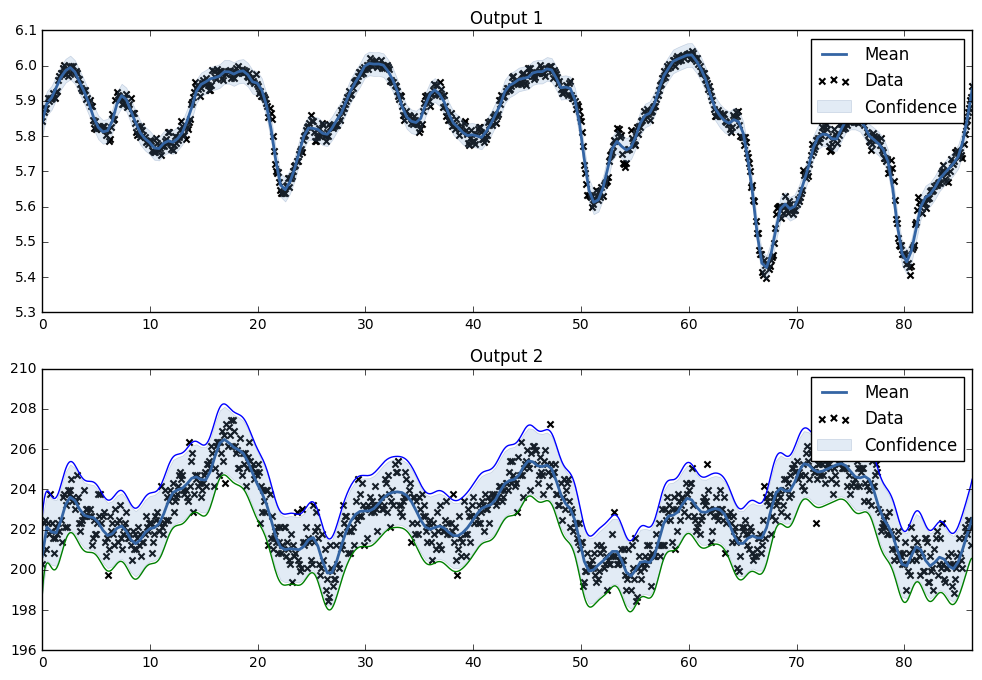

In [16]:
plot_2outputs(mul1, xlim=(0,x_d1[len(x_d1)-1]),x_1=x_d1,x_2=x_d1)
plt.plot(x_d1,con_u)
plt.plot(x_d1,con_l)
plt.show()

In [10]:
Xc,Yc,Ic = build_XY([x_d1,x_d1],[y1_d1_t,y2_d1_t])
mu_t,var_t = mul1.predict(Xc,Y_metadata=Ic,kern=mul1.kern,likelihood=mul1.likelihood)
mu2_t = mu_t[int(len(mu_t)/2):len(mu_t)]
var2_t = var_t[int(len(mu_t)/2):len(mu_t)]
con_ue = mu2_t + np.sqrt(var2_t)*zp
con_le = mu2_t - np.sqrt(var2_t)*zp
plot_2outputs(mul1, xlim=(0,x_d1[len(x_d1)-1]),x_1=x_d1,x_2=x_d1)
plt.plot(x_d1,con_ue,'blue')
plt.plot(x_d1,con_le,'blue')
plt.show()

NameError: name 'mul1' is not defined

In [58]:
np.sqrt(6*np.ones(len(mu2_t))[:,None]-np.log(2*np.pi*var2_t))

array([[ 2.06701024],
       [ 2.10054955],
       [ 2.1143982 ],
       [ 2.11978802],
       [ 2.12246945],
       [ 2.12443715],
       [ 2.1260259 ],
       [ 2.12714545],
       [ 2.12778439],
       [ 2.12809361],
       [ 2.12829395],
       [ 2.12856356],
       [ 2.12897691],
       [ 2.12950585],
       [ 2.13006127],
       [ 2.13054595],
       [ 2.13089528],
       [ 2.13109481],
       [ 2.13117483],
       [ 2.13119047],
       [ 2.13119821],
       [ 2.13123759],
       [ 2.13132321],
       [ 2.13144681],
       [ 2.13158656],
       [ 2.13171843],
       [ 2.13182532],
       [ 2.13190136],
       [ 2.13195099],
       [ 2.13198477],
       [ 2.13201399],
       [ 2.1320465 ],
       [ 2.13208476],
       [ 2.13212635],
       [ 2.13216622],
       [ 2.13219952],
       [ 2.13222392],
       [ 2.13224039],
       [ 2.13225252],
       [ 2.13226475],
       [ 2.13228055],
       [ 2.13230116],
       [ 2.13232537],
       [ 2.13235025],
       [ 2.1323724 ],
       [ 2

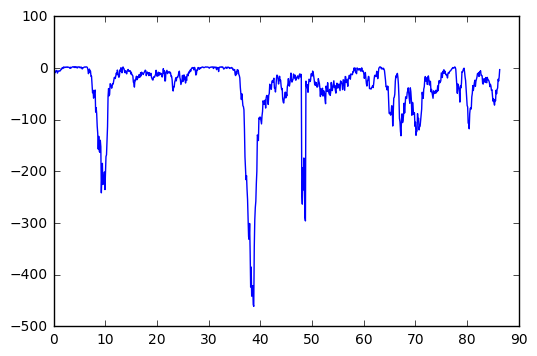

In [31]:
pre_like = np.zeros(len(x_d1))
for i in range(len(x_d1)):
    X,Y = make_test(training_x = x_d1, training_y1 = y1_d1_t, training_y2 = y2_d1_t, test_x = x_d1[i], test_y1 = y1_d1[i], test_y2 = y2_d1[i])
    pre_like[i] = pred_likelihood(mul1, X, Y, mul1.kern, len(x_d1))
plt.plot(x_d1, pre_like)
plt.show()

In [43]:
X,Y = make_test(training_x = x_d1, training_y1 = y1_d1_t, training_y2 = y2_d1_t, test_x = x_d1[0], test_y1 = y1_d1[0], test_y2 = y2_d1[0])
p = pred_likelihood(mul1, X, Y, mul1.kern, len(x_d1))

[[ 0.08529458]
 [ 1.61482312]]


In [20]:
X,Y,I = build_XY([x_d1,x_d1],[y1_d1,y2_d1])
mu,var = mul1.predict(X,Y_metadata=I,kern=mul1.kern,likelihood=mul1.likelihood)
mu_2 = mu[int(len(var)/2):len(var)]
var_2 = var[int(len(var)/2):len(var)]

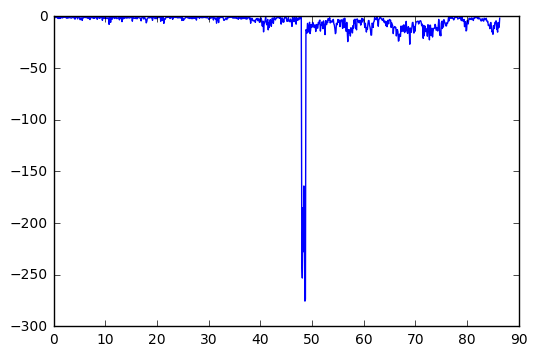

In [29]:
ano = np.zeros(len(var_2))
for i in range(len(var_2)):
    ano[i] = -np.log(2*np.pi*var_2[i])/2 - ((y2_d1[i]-mu_2[i])**2)/(2*var_2[i])
plt.plot(x_d1, ano)
plt.show()

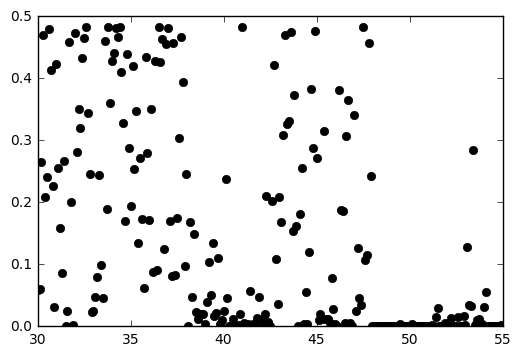

In [34]:
k = np.exp(ano)
plt.plot(x_d1[300:550],k[300:550],'ko')
plt.show()

In [69]:
K3 = GPy.kern.PeriodicMatern52(1)
lcm2 = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[K1,K2,K1])
mul2 = GPy.models.GPCoregionalizedRegression([x_d1,x_d1[0:804]],[y1_d1_t,y2_d1_t[0:804]],kernel = lcm2)
mul2.optimize()

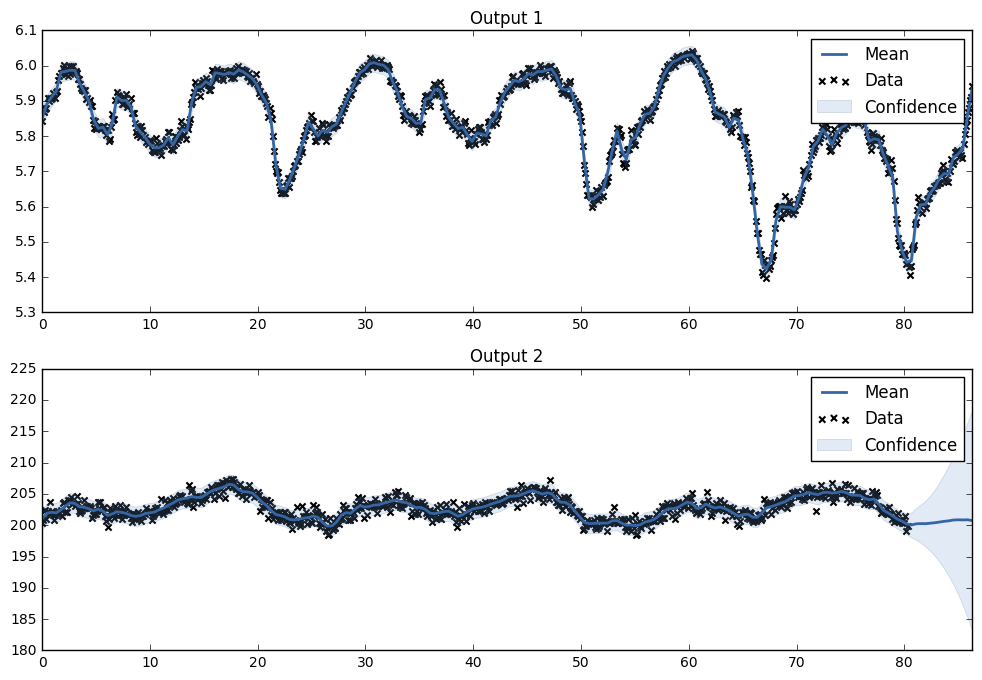

In [70]:
plot_2outputs(mul2, xlim=(0,x_d1[len(x_d1)-1]),x_1=x_d1,x_2=x_d1)
plt.show()

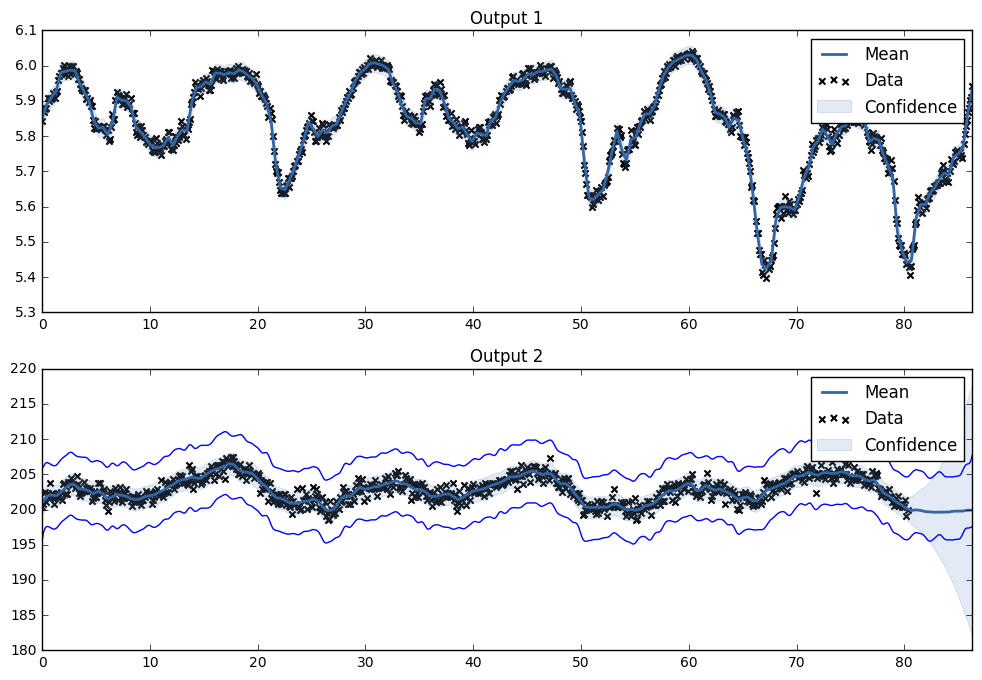

In [67]:
Xc,Yc,Ic = build_XY([x_d1,x_d1],[y1_d1_t,y2_d1_t])
mu_t,var_t = mul1.predict(Xc,Y_metadata=Ic,kern=mul1.kern,likelihood=mul1.likelihood)
mu2_t = mu_t[int(len(mu_t)/2):len(mu_t)]
var2_t = var_t[int(len(mu_t)/2):len(mu_t)]
con_ue = mu2_t + np.sqrt(var2_t)*zp
con_le = mu2_t - np.sqrt(var2_t)*zp
plot_2outputs(mul2, xlim=(0,x_d1[len(x_d1)-1]),x_1=x_d1,x_2=x_d1)
plt.plot(x_d1,con_ue,'blue')
plt.plot(x_d1,con_le,'blue')
plt.show()

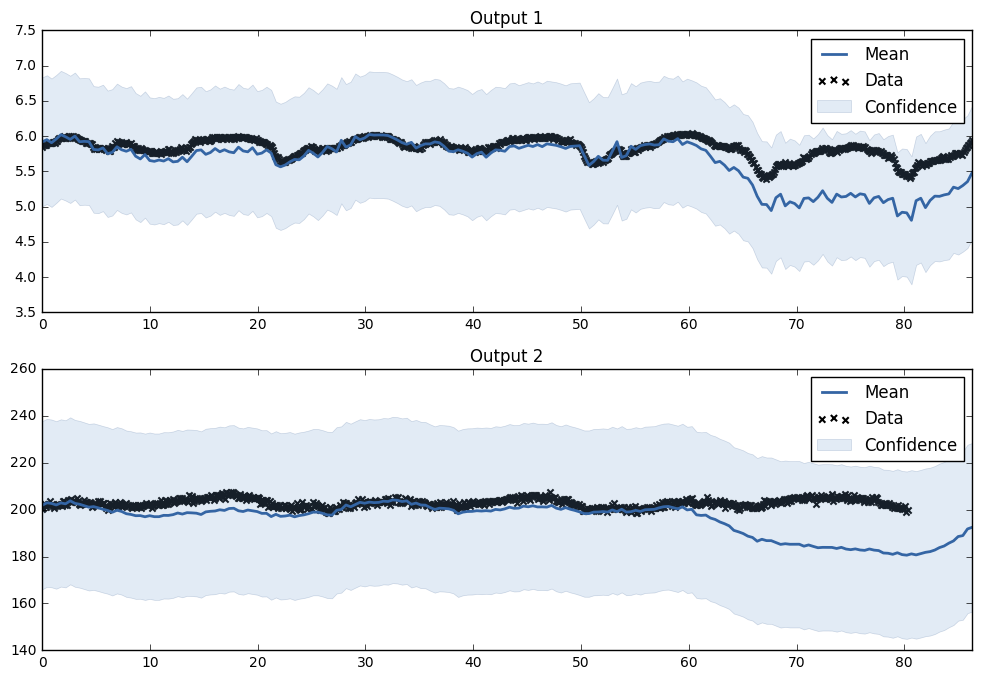

In [65]:
plot_2outputs(mul2, xlim=(0,x_d1[len(x_d1)-1]),x_1=x_d1,x_2=x_d1)
plt.show()

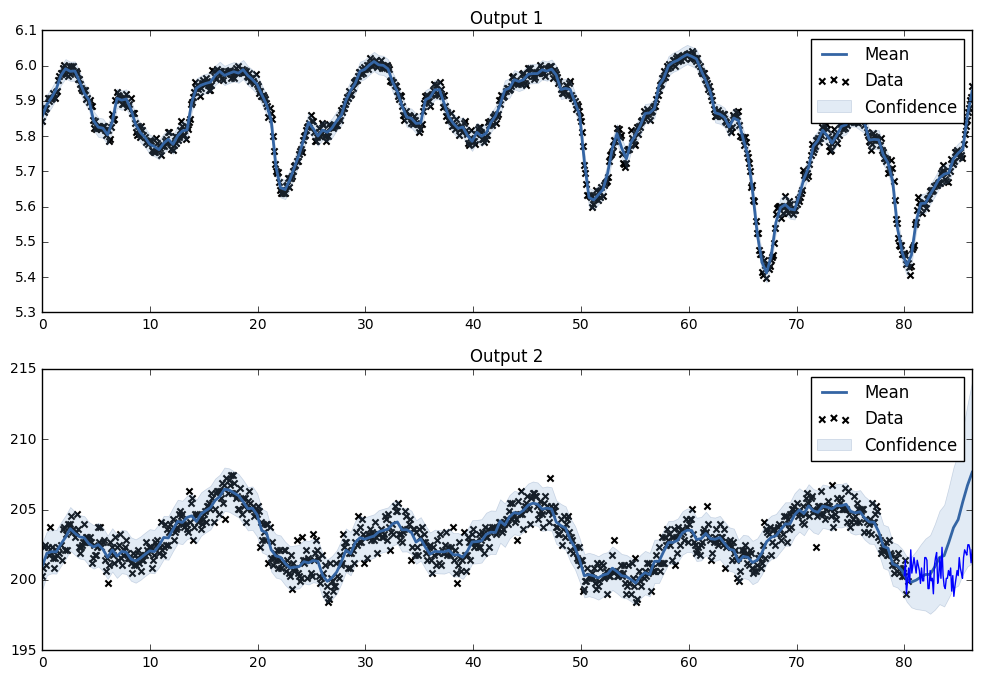

In [58]:
plot_2outputs(mul2, xlim=(0,x_d1[len(x_d1)-1]),x_1=x_d1,x_2=x_d1)
plt.plot(x_d1[800:len(x_d1)],y2_d1_t[800:len(x_d1)])
plt.show()